In [1]:
import pandas as pd

file_name = "../scraped_data.csv"


df = pd.read_csv(file_name)

print(df.shape)


(2510, 2)


In [2]:
print(df.columns)

Index(['https://databricks.com/blog/2014/01/01/simr.html', '<html lang="en-US" data-react-helmet="lang"><head><script async="" src="https://ml314.com/tag.aspx?2811"></script><script type="text/javascript" async="" src="https://j.6sc.co/6si.min.js" class="optanon-category-C0002-C0003-C0004 "></script><script type="text/javascript" async="" src="//siteimproveanalytics.com/js/siteanalyze_6092549.js" class="optanon-category-C0002 "></script><script type="text/javascript" async="" src="https://snap.licdn.com/li.lms-analytics/insight.min.js" class="optanon-category-C0004 "></script><script type="text/javascript" async="" src="https://bat.bing.com/bat.js" class="optanon-category-C0004 "></script><script type="text/javascript" async="" src="https://static.ads-twitter.com/uwt.js"></script><script type="text/javascript" async="" src="https://www.redditstatic.com/ads/pixel.js" class="optanon-category-C0004 "></script><script type="text/javascript" async="" src="https://static.ads-twitter.com/uwt.

In [3]:
# name the first column url second column content
df.columns = ['url', 'content']

In [4]:
# check if there is any duplicated value for the column "url"

print(df["url"].duplicated().any())
# count the number of duplicated urls

print(df["url"].duplicated().sum())

# print the duplicated urls
print(df[df["url"].duplicated()])

True
1
                           url  \
4  https://databricks.com/blog   

                                             content  
4  <html lang="en-US" data-react-helmet="lang"><h...  


In [5]:
from bs4 import BeautifulSoup
from markdownify import markdownify as md
from df_utils import apply_parallel

def extract_md(html_content):
    soup = BeautifulSoup(html_content, "html.parser")
    # 1. For blogs: look for the "main" element
    main_element = soup.find("main")
    if main_element is not None:
        main_html = main_element.prettify()
        markdown_text = md(main_html)
        return markdown_text
    # 2. for docs
    div_element = soup.find('div', {'itemprop': 'articleBody'})
    if div_element is None:
        # this won't work, since the element is dynamically rendered
        div_element = soup.find('article', {'role': 'main'})

        if div_element is None:
            return None 
        else:
            print("found article element")
    div_html = div_element.prettify()
    markdown_text = md(div_html)        
    return markdown_text


def extract_md_row(row):
    url = row["url"]
    content = row["content"]
    markdown_text = extract_md(content)

    # stripe the leading and trailing spaces
    markdown_text = markdown_text.strip()
    # replace 2+ new lines with 1 new line
    markdown_text = markdown_text.replace("\n\n+", "\n") 

    row["md"] = markdown_text
    return [row]


df_with_md, status_df = apply_parallel(df, extract_md_row, max_workers=100)

df_with_md

Processing rows (Success: 2510, Failures: 0): 100%|██████████| 2510/2510 [00:00<00:00, 3322.36it/s]


,url,content,md
639,https://databricks.com/blog/author/roberto-san...,"<html lang=""en-US"" data-react-helmet=""lang""><h...",Categories\n------------\n\n\n\n\n\n\n\n\n\n\n...
704,https://databricks.com/blog/author/david-veuve,"<html lang=""en-US"" data-react-helmet=""lang""><h...",Categories\n------------\n\n\n\n\n\n\n\n\n\n\n...
2394,https://databricks.com/blog/2023/01/25/loading...,"<html lang=""en-US"" data-react-helmet=""lang""><h...",Loading a Data Warehouse Slowly Changing Dimen...
713,https://databricks.com/blog/author/tasha-thakkar,"<html lang=""en-US"" data-react-helmet=""lang""><h...",Categories\n------------\n\n\n\n\n\n\n\n\n\n\n...
66,https://databricks.com/blog/databricks-data-in...,"<html lang=""en-US"" data-react-helmet=""lang""><h...",Databricks Data Intelligence Platform for Reta...
...,...,...,...
2053,https://databricks.com/blog/author/timo-roest,"<html lang=""en-US"" data-react-helmet=""lang""><h...",Categories\n------------\n\n\n\n\n\n\n\n\n\n\n...
1287,https://databricks.com/blog/2022/07/15/hunting...,"<html lang=""en-US"" data-react-helmet=""lang""><h...",Hunting for IOCs Without Knowing Table Names o...
1767,https://databricks.com/blog/author/ka-hing-cheung,"<html lang=""en-US"" data-react-helmet=""lang""><h...",Categories\n------------\n\n\n\n\n\n\n\n\n\n\n...
1288,https://databricks.com/blog/author/chengyin-eng,"<html lang=""en-US"" data-react-helmet=""lang""><h...",Categories\n------------\n\n\n\n\n\n\n\n\n\n\n...


In [6]:
# count number of rows where md is None

print(df_with_md["md"].isnull().sum())



0


In [7]:
# show the first 5 rows of the md column, get rid of the row width limit
pd.set_option('display.max_colwidth', None)
df_with_md["md"].head(3)


639                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

(2510, 3)


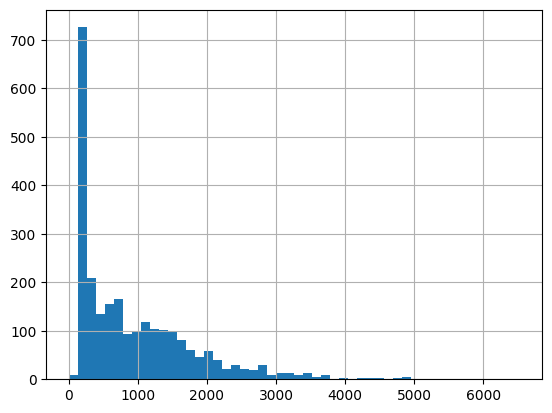

In [8]:
print(df_with_md.shape)
# count the number of words in the md column and plot the histogram
df_with_md["md"].str.split().str.len().hist(bins=50)

# remove the rows where md has less than 100 words
df_with_md = df_with_md[df_with_md["md"].str.split().str.len() > 100]



(2503, 3)


<Axes: >

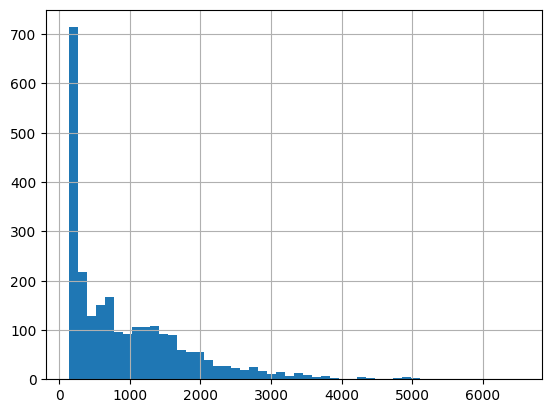

In [9]:
print(df_with_md.shape)
df_with_md["md"].str.split().str.len().hist(bins=50)

In [10]:
# show the 5 rows that has the least number of words
df_with_md.sort_values(by="md").head(5)[["url", "md"]]

url  \
2079                                                    https://databricks.com/blog/2015/02/09/learning-spark-book-available-from-oreilly.html   
2110                                        https://databricks.com/blog/2020/08/25/tensorboard-a-new-way-to-use-tensorboard-on-databricks.html   
964                                               https://databricks.com/blog/2020/03/31/10-minutes-from-pandas-to-koalas-on-apache-spark.html   
1292  https://databricks.com/blog/2021/11/11/10-powerful-features-to-simplify-semi-structured-data-management-in-the-databricks-lakehouse.html   
591                                     https://databricks.com/blog/2021/10/28/100-years-of-horror-films-an-analysis-using-databricks-sql.html   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

(1102, 3)


<Axes: >

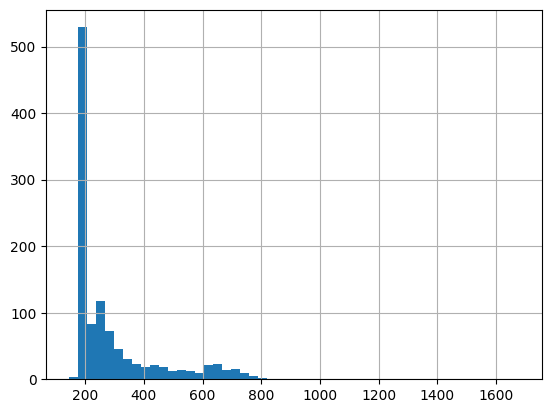

In [11]:
# get rows where the url contains "author"

df_author = df_with_md[df_with_md["url"].str.contains("author")]
print(df_author.shape)

# plot the histogram of the number of words in the md column
df_author["md"].str.split().str.len().hist(bins=50)

In [12]:
# get the row where url is "https://databricks.com/blog/author/anindita-mahapatra/page/15"

df_author[df_author["url"] == "https://databricks.com/blog/author/anindita-mahapatra/page/15"]

,url,content,md
